In [1]:
%matplotlib inline
from IPython.display import clear_output

import gc
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from tqdm import tqdm

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras import initializers
import sys
sys.path.append('/home/art/Programming/artlibs')
from artiom_convenience_functions import * 
from videorecorder import save_to_video, execute_at_exit



In [2]:
def s(img):
    plt.imshow(
    img.reshape(
    N_DIM, N_DIM), cmap='gray')

In [3]:
N_DIM = 28
faces = np.fromfile(f"girls_img_{N_DIM}x{N_DIM}.bin", dtype="uint8").reshape(-1, N_DIM * N_DIM) / 255

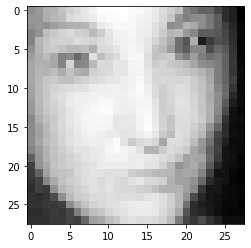

In [4]:
s(faces[2])

# Face generator

In [47]:
inputs = keras.Input(shape=(100))
x = Dense(100, activation='sigmoid')(inputs)
x = Dense(1000, activation='sigmoid')(x)
outputs = Dense(N_DIM ** 2, activation='sigmoid')(x)
face_gen = keras.Model(inputs=inputs, outputs=outputs, name="face_generator")

face_gen.compile(

    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["accuracy"],
)


# policeman 

In [48]:
inputs = keras.Input(shape=(N_DIM ** 2))
x = Dense(1000, activation='sigmoid')(inputs)
outputs = Dense(1, activation='sigmoid')(x)
policeman = keras.Model(inputs=inputs, outputs=outputs, name="policeman")

In [49]:

policeman.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["accuracy"],
)

# Среда

In [50]:
policeman.trainable = False
inputs = keras.Input(shape=(100))
x = face_gen(inputs)
outputs = policeman(x) 
env_model = keras.Model(inputs=inputs, outputs=outputs, name="face_generator")

In [51]:

env_model.compile( loss="MSE" 
)

In [52]:
env_model.summary()

Model: "face_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 face_generator (Functional)  (None, 784)              895884    
                                                                 
 policeman (Functional)      (None, 1)                 786001    
                                                                 
Total params: 1,681,885
Trainable params: 895,884
Non-trainable params: 786,001
_________________________________________________________________


1/1 [==============================] - 0s 61ms/step


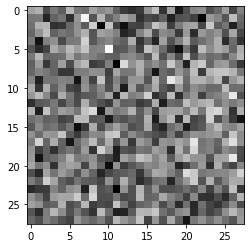

In [53]:
s(
    face_gen.predict(
        np.random.random(size=100).astype("float32").reshape(1, 100)
    ).reshape(N_DIM, N_DIM))

# Учим полицейского

In [54]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

In [55]:
faces_drawn_from_seeds = face_gen.predict(seeds)

10/10 [==============================] - 0s 2ms/step


In [56]:

indices = np.random.randint(0, len(faces), size=N)
real_faces = faces[indices]

In [57]:
X = np.concatenate([faces_drawn_from_seeds, real_faces])
X.shape

(628, 784)

In [58]:
Y = np.zeros(
N * 2)

Y[N:] = 1

In [59]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

1.0


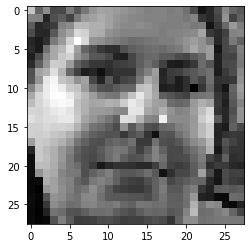

In [60]:
x, y = X[ind:=np.random.randint(0, len(X))],   Y[ind]
print(y)
s(x)

In [61]:
policeman.fit(X, Y, epochs=1, shuffle=1)
policeman.evaluate(X, Y)

20/20 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.9920


[0.4460926055908203, 0.9920381903648376]

# Теперь запускаем срелу

In [62]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

ones = np.ones(len(seeds), dtype="float32").reshape(-1, 1)


In [63]:
ones.shape

(314, 1)

In [64]:

seeds[0]

array([0.39015839, 0.32047784, 0.6400081 , 0.30094343, 0.23447505,
       0.961243  , 0.9342645 , 0.49755868, 0.20135891, 0.48975363,
       0.8079158 , 0.17340048, 0.74786466, 0.40360737, 0.04812456,
       0.93591684, 0.6157523 , 0.441319  , 0.53229165, 0.9542655 ,
       0.9354107 , 0.6568511 , 0.44139588, 0.76647264, 0.79463124,
       0.24224973, 0.52475953, 0.9879841 , 0.4964697 , 0.34341437,
       0.51346695, 0.70614064, 0.04526762, 0.88921106, 0.12421647,
       0.6034717 , 0.39970994, 0.12823226, 0.81303734, 0.4339143 ,
       0.8827612 , 0.32576987, 0.7572157 , 0.40533796, 0.25805295,
       0.13438486, 0.5365228 , 0.14374019, 0.8209075 , 0.37986082,
       0.11966461, 0.54607403, 0.90132385, 0.8928998 , 0.13226697,
       0.8579472 , 0.14058056, 0.06541643, 0.7343183 , 0.35535914,
       0.77508795, 0.83971936, 0.22548844, 0.5061207 , 0.0027692 ,
       0.16498642, 0.9629188 , 0.70234513, 0.4888025 , 0.01381415,
       0.6526996 , 0.8432889 , 0.03892082, 0.97346914, 0.51656

In [65]:
env_model.fit(seeds, ones, shuffle=1, epochs=1)

10/10 [==============================] - 0s 4ms/step - loss: 0.0456


# В цикле

In [66]:
faces_drawn_from_seeds[0]

array([0.61438876, 0.6531548 , 0.386648  , 0.49849305, 0.44083682,
       0.6654767 , 0.50660163, 0.47413066, 0.6155255 , 0.55053896,
       0.57648903, 0.43676817, 0.3511715 , 0.31678697, 0.35342574,
       0.5758026 , 0.6920309 , 0.32580373, 0.6113828 , 0.2599107 ,
       0.39503226, 0.538586  , 0.5553429 , 0.40672582, 0.46821126,
       0.6033671 , 0.37281278, 0.533366  , 0.5044116 , 0.50984126,
       0.28782454, 0.4602436 , 0.48933825, 0.3162599 , 0.5878322 ,
       0.82849073, 0.41570616, 0.65937215, 0.44764903, 0.52677375,
       0.63065   , 0.57068825, 0.32456297, 0.3854066 , 0.37122414,
       0.44681564, 0.28810045, 0.41285333, 0.4132294 , 0.3623539 ,
       0.20966575, 0.58686817, 0.5439159 , 0.41925812, 0.6811166 ,
       0.4712052 , 0.4888963 , 0.66034883, 0.66600686, 0.3228916 ,
       0.3374365 , 0.47166705, 0.570598  , 0.43825486, 0.72963804,
       0.22179519, 0.700374  , 0.35474625, 0.23250693, 0.37428236,
       0.3614839 , 0.468887  , 0.6987899 , 0.6220226 , 0.35964

In [74]:
key = None
while key not in (27,):
    N = 140
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)
    faces_drawn_from_seeds = face_gen.predict(seeds, verbose=0)

    
    
    best_ind = np.argmax(policeman.predict(faces_drawn_from_seeds).reshape(-1))
    cv2.imshow("result", resize(faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
                               interpolation=cv2.INTER_NEAREST))
    key = cv2.waitKey(1)

    indices = np.random.randint(0, len(faces), size=N)
    real_faces = faces[indices]
    X = np.concatenate([faces_drawn_from_seeds, real_faces])
    Y = np.zeros(
    N * 2)

    Y[N:] = 1


    policeman.fit(X, Y, epochs=5, shuffle=1, verbose=0)
    policeman.evaluate(X, Y, verbose=0)






    N = 140
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

    ones = np.ones(len(seeds)).reshape(-1, 1)
    env_model.fit(seeds, ones, shuffle=1, epochs=1, verbose=0)

5/5 [==============================] - 0s 1ms/step
